In [1]:
import numpy as np
import gpkit
from gpkit import Model, Variable
import gpkit.interactive
from gpkit.nomials.nomial_math import SingleSignomialEquality,SignomialInequality
from gpkit import units
from gpkit.constraints.tight import Tight 
from gpkit.constraints.bounded import Bounded
from math import *
gpkit.SIGNOMIALS_ENABLED = True

Physical constants:

In [2]:
sigma = Variable("\\sigma", 5.67e-8, "W / m^2 / K^4", "Stefan-Botlzman constant")
k = Variable("k", 1.380658e-23, "J/K", "Boltzman constant R/Na")
mu_earth = Variable("\\mu_e", 3.986e14, "m^3 / s^2", "GM Earth")
c = Variable("c", 299792458, "m/s", "Speed of light in vacuum")
Q_s = Variable("Q_s", 1367, "W/m^2", "solar flux constant")
R_earth = Variable("R_e", 6371, "km", "earth radius")

Free parameters
- Note: challenge between which parameter to use, semi-major axis or altitude

In [3]:
#a = gpkit.Variable("a", "m", "semi-major axis") # our variable of interest is actually altitude
#dd = Variable("d","m","dummy2")
#T = gpkit.Variable("T", "s", "orbit time")

Equations

In [4]:
surrogate_constant = gpkit.Variable('surr', 0.00010385799808613171, '1/km', 'surrogate value')
factor  = gpkit.Variable('f', 6800.0, 'km', 'a dilution factor')

In [5]:
equations = []

#a = h + R_earth
#day_fraction = 0.00010385799808613171*a-0.092494738209717195 # surrogate

#equations += [
#     Tight([day_fraction <= surrogate_constant*a-0.092494738209717195]),
#    SingleSignomialEquality(day_fraction,surrogate_constant*a - 0.0924847)]

In [31]:
class Comms(Model):
    def setup(self):
        rgs = Variable("Rgs", "km", "max distance to ground station")
        rgsmin = Variable("Rgsmin", 10, "km", "minimum rgs")
        rgsmax = Variable("Rgsmax", 10000, "km", "maximum rgs")
        
        tf = Variable("tx_f", 2.2, "GHz", "transmit frequency")
        tl = Variable("tx_l", "m", "transmit wavelength")
        
        brate = Variable("brate", 85, "Mbps", "bit rate required")
        
        PT = Variable("P_tx", "W", "spacecraft transmit power")
        PTmin = Variable("PTmin", 0.0001, "W", "min PT")
        PTmax = Variable("PTmax", 500, "W", "max PT")
        
        tD = Variable("tx_D", 0.3, "m", "spacecraft antenna diameter")
        Lpt = Variable("L_pt", 0.1412, "-", "pointing loss")
        Ll = Variable("L_l", 0.1, "-", "line loss")
        #tG = Variable("tx_G", "-", "transmit gain")
        #EIRP = Variable("EIRP", "W", "Equivalent Isotropic Received Power")
        #pl = Variable("pl", "-", "path loss")
        
        rG = Variable("rG", "-", "ground receive gain")
        rD = Variable("rD", 5.3, "m", "ground receive diamater")
        Tsys = Variable("Tsys", 135, "K", "system temperature")
        eta = Variable("\\eta", 0.55, "-", "dish efficiency")
        ebno_req = Variable("ebno_{req}", 25, "-", "ebno required")
        
        ebno = Variable("ebno", "-", "engery per bit over noise spectral density")
        
        return [
            #EIRP <= tG * PT,
            rgs <= rgsmax,
            rgs >= rgsmin,
            PT <= PTmax,
            PTmin <= PT,
            tl == c / tf,
            rG <= eta*(pi * rD/tl)**2, # SMAD 3 p. 556
            ebno == PT * Ll * eta * (tD**2 / rgs**2) * Lpt * rG / (k * Tsys * brate),
            ebno_req <= ebno
        ]

In [32]:
class Payload(Model):
    def setup(self):
        l = Variable("\\lambda", 500, "nm", "image payload wavelength")
        D = Variable("D_{ap}", "m", "aperture")
        Dmin = Variable("Dmin", 0.001, "m", "minimum aperture size")
        Dmax = Variable("Dmax", 0.2, "m", "maximum aperture size")
        mass = Variable("mass_pay", "kg", "payload mass")
        
        return [
            D >= Dmin,
            D <= Dmax,
            mass == 100*units("kg/m**1.5")*D**1.5
        ]

In [8]:
class TestComms(Model):
    def setup(self):
        self.comms = Comms()
        h = gpkit.Variable("h", "km", "altitude")
        h_min = gpkit.Variable('h_{min}', 2831, 'km', 'minimum altitude')
        h_max = gpkit.Variable('h_{max}', 30000, 'km', 'maximum altitude')
        
        constraints = [
            h >= h_min,
            h <= h_max,
            h*h + 2*h*R_earth <= self.comms["Rgs"]**2
        ]
        
        self.cost = self.comms["P_tx"]
        
        return constraints, self.comms

In [9]:
co = TestComms()

In [10]:
sol = co.solve()

Using solver 'mosek_cli'
Solving for 6 variables.
Solving took 0.119 seconds.


In [11]:
print sol.table()


Cost
----
 30.43 [W] 

Free Variables
--------------
     | TestComms
   h : 2831            [km] altitude

     | TestComms/Comms
P_tx : 30.43           [W]  transmit power
 Rgs : 6640            [km] max distance to ground station
ebno : 25                   engery per bit over noise spectral density
  rG : 8211                 receive gain
tx_l : 0.1363          [m]  transmit wavelength

Constants
---------
       R_e : 6371            [km]  earth radius
         c : 2.998e+08       [m/s] Speed of light in vacuum
         k : 1.381e-23       [J/K] Boltzman constant R/Na

           | TestComms
   h_{max} : 3e+04           [km]  maximum altitude
   h_{min} : 2831            [km]  minimum altitude

           | TestComms/Comms
       L_l : 0.1                   line loss
      L_pt : 0.1412                pointing loss
     PTmax : 500             [W]   max PT
     PTmin : 0.0001          [W]   min PT
    Rgsmax : 1e+04           [km]  maximum rgs
    Rgsmin : 10              [km]  m

In [12]:
var = sol["variables"]

In [13]:
Ls = 20*log10(var["tx_l"]/(4*pi*var["Rgs"]))

In [14]:
Gt = 10*log10(0.55*(pi*var["tx_D"]/var["tx_l"])**2) - 8.5

In [15]:
P = 10*log10(var["P_tx"].magnitude)

In [16]:
Gr = 10*log10(0.55*(pi*var["rD"]/var["tx_l"])**2) - 0.1

In [17]:
10*log10(var["k"].magnitude)

-228.5991388630708

In [18]:
T = 10*log10(var["Tsys"].magnitude)

In [19]:
R = 10*log10(var["brate"].magnitude*1e6)

In [20]:
#EIRP+Ls+Gr+228.6-T-R-0.3

In [21]:
10**(-8.5/10)

0.14125375446227545

In [22]:
var["ebno"]

25.000004378295362

In [23]:
10*log10(var["ebno"])

13.979400847308117

In [33]:
class Power(Model):
    def setup(self):
        P = Variable("P", "W", "spacecraft total power")
        A = Variable("A", "m^2", "surface area solar panels")
        amax = Variable("amax", 100, "m^2", "surface area max")
        amin = Variable("amin", 0.001, "m^2", "surface area min")
        day_fraction = Variable("td", "-", "not in-eclipse fraction")
        tdmax = Variable("tdmax", 0.8, "-")
        tdmin = Variable("tdmin", 0.3, "-")
        sa_spc_ene = Variable('spc', 15, 'W/kg', 'power density of solar arrays') 
        eta_s = Variable("\\eta_s", 0.29, "-", "solar panel efficiency")
        surrogate_constant = Variable('surr', 0.00010385799808613171, '1/km', 'surrogate value')
        P_min  = Variable('P_{min}', 0.1, 'W', 'min power')
        P_max  = Variable('P_{max}', 4000, 'W', 'max power')
        mass_p = Variable("mass_p", 'kg', 'power subsystem mass')
        return [
            P >= P_min,
            P <= P_max,
            A <= amax,
            A >= amin,
            day_fraction <= tdmax,
            day_fraction >= tdmin,
            P == day_fraction * A * eta_s * Q_s,
            mass_p >= P/sa_spc_ene
        ]

In [34]:
class Satellite(Model):
    def setup(self):
        mass = gpkit.Variable("m_t", 'kg', 'spacecraft total mass')
        
        constraints = []
        
        self.power = Power()
        self.comms = Comms()
        self.payload = Payload()
        
        constraints.extend([
            self.power["P"] >= self.comms["P_tx"],
            mass >= self.power["mass_p"] + self.payload["mass_pay"]
        ])
        
        return constraints, self.power, self.comms, self.payload

In [41]:
class Mission(Model):
    def setup(self):
        h = Variable("h", "km", "orbit altitude")
        h_min = Variable('h_{min}', 400, 'km', 'minimum orbit altitude')
        h_max = Variable('h_{max}', 800, 'km', 'maximum orbit altitude')
        #dum1 = Variable('dum1','-')
        Xp = Variable('xp', 'm', 'diffraction limited resolution')
        Xp_req = Variable('xp_{req}', 10, 'm', 'required resolution')
        
        satellite = Satellite()
        self.satellite = satellite
        # could access items without going into subsystems, but feel this keeps it cleaner
        power = satellite.power
        comms = satellite.comms
        payload = satellite.payload
        
        constraints = [
            SingleSignomialEquality(power["td"], surrogate_constant*(h+R_earth)),
            h >= h_min,
            #h <= h_max,
            Xp == 1.22 * h * payload["\\lambda"]/payload["D_{ap}"],
            Xp <= Xp_req,
            SingleSignomialEquality(h*h + 2*h*R_earth, comms["Rgs"]**2)
        ]
        
        self.cost = satellite["m_t"] #+ h*units('kg/km')
        
        return constraints, satellite

In [42]:
m = Mission()

In [43]:
m.substitutions.update({'xp_{req}':('sweep', [5])})
m.substitutions.update({'ebno_{req}':('sweep', [10,15,25])})

In [44]:
sol = m.localsolve()

Solving over 3 passes.
Sweeping took 0.765 seconds.


In [45]:
print sol.table()


Cost
----
 [ 1.17      1.22      1.32      ] [kg] 

Sweep Variables
---------------
           | Mission.2
  xp_{req} : [ 5         5         5        ]  [m] required resolution

           | Mission.2/Satellite.2/Comms.3
ebno_{req} : [ 10        15        25       ]      ebno required

Free Variables
--------------
         | Mission.2
       h : [ 400       400       400      ]  [km]   orbit altitude
      xp : [ 5         5         5        ]  [m]    diffraction limited resolution

         | Mission.2/Satellite.2
     m_t : [ 1.17      1.22      1.32     ]  [kg]   spacecraft total mass

         | Mission.2/Satellite.2/Comms.3
    P_tx : [ 1.45      2.18      3.63     ]  [W]    spacecraft transmit power
     Rgs : [ 2.29e+03  2.29e+03  2.29e+03 ]  [km]   max distance to ground station
    ebno : [ 10        15        25       ]         engery per bit over noise spectral density
      rG : [ 8.21e+03  8.21e+03  8.21e+03 ]         ground receive gain
    tx_l : [ 0.136     0.136    

Day fraction fitting

In [454]:
Re = 6378
rmin = Re+400
rmax = Re+800
rar = np.linspace(rmin, rmax)
har = np.linspace(400, 800)
te = 1-np.arcsin(Re/rar)/pi

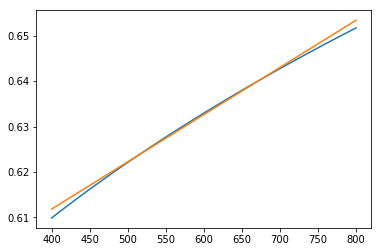

In [743]:
%matplotlib inline
#http://stackoverflow.com/questions/29382903/how-to-apply-piecewise-linear-fit-in-python
import matplotlib.pyplot as plt
from scipy import optimize
def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])
p , e = optimize.curve_fit(piecewise_linear, rar, te)
z = np.poly1d(np.polyfit(har,te,1))
plt.plot(har, te)
#plt.plot(rar, piecewise_linear(rar, *p))
plt.plot(har, z.coeffs[0]*rar+z.coeffs[1]-0.662)
plt.show()

In [27]:
z.coeffs[0]/z.coeffs[1]

-0.001122853041117324

In [30]:
z.coeffs[1]

-0.092494738209717195